In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange

import warnings
warnings.filterwarnings('ignore')

np.random.seed(43)

In [59]:
iris_data = pd.read_csv('iris.data')
print(iris_data.head())

# Column names
column_name = ['Sepal_length', 'Sepal_width', 'Petal_length', 'Petal_width', 'Class']

iris_data.columns = column_name

   5.1  3.5  1.4  0.2  Iris-setosa
0  4.9  3.0  1.4  0.2  Iris-setosa
1  4.7  3.2  1.3  0.2  Iris-setosa
2  4.6  3.1  1.5  0.2  Iris-setosa
3  5.0  3.6  1.4  0.2  Iris-setosa
4  5.4  3.9  1.7  0.4  Iris-setosa


# https://www.kaggle.com/grim1412/seaborn-visualization-and-knn-on-the-iris-dataset

In [60]:
unique_class = iris_data['Class'].unique()

# this unique class will be our no of clusters
num_of_clusters = len(unique_class)
print(num_of_clusters)

3


In [61]:
def categorical_to_numerical(c):

  """ this method is to convert categorical value to numerical value
  :type c: string

  :rtype: a number denoting class
  """
  if c.lower() == 'iris-setosa':
    return 1
  elif c.lower() == 'iris-versicolor':
    return 2
  elif c.lower() == 'iris-virginica':
    return 3

iris_data['Class'] = iris_data['Class'].map(lambda c: categorical_to_numerical(c))
iris_data.head()

,Sepal_length,Sepal_width,Petal_length,Petal_width,Class
0,4.9,3.0,1.4,0.2,1
1,4.7,3.2,1.3,0.2,1
2,4.6,3.1,1.5,0.2,1
3,5.0,3.6,1.4,0.2,1
4,5.4,3.9,1.7,0.4,1


In [62]:
print("iris_data shape :: ", iris_data.shape)

feature = iris_data.drop(['Class'], axis=1) # let's call X as feature
cluster = iris_data['Class'] # let's call y as cluster

print("feature Shape :", feature.shape)
print("cluster Shape :", cluster.shape)

iris_data shape ::  (149, 5)
feature Shape : (149, 4)
cluster Shape : (149,)


In [63]:
class KMeansClustering():
    def __init__(self, dataframe, K) -> None:
        self.centroids = None
        self.K = K
        self.dataframe = dataframe
        self.initialize_centroids(self.dataframe)

    def initialize_centroids(self, dataframe):
        self.centroids = {}

        random_index = np.random.choice(len(dataframe), self.K, replace=False)
        i = 0
        for k in range(1, self.K+1):
            idx = random_index[i]
            random_centroid = dataframe.iloc[idx]
            i += 1
            self.centroids[k] = random_centroid.tolist()
        print("Initialized Centroids are  :: ", self.centroids)

    # calculate euclidean distance
    def calculate_euclidean_distance(self, X, centroid_points):
        total_distance = 0
        total_distance = np.sqrt((X['Sepal_length'] - centroid_points[0]) ** 2 + (X['Sepal_width'] - centroid_points[1]) ** 2
                       + (X['Petal_length'] - centroid_points[2]) ** 2 + (X['Petal_width'] - centroid_points[3]) ** 2)
        # print("total_distance :: ", total_distance)
        return np.square(total_distance)

    def get_euclidean_norm_distance(self, point_array_1, point_array_2):
        return np.linalg.norm(point_array_1 - point_array_2)
    
    def assign_centroid(self, X):
        for centroid in self.centroids.keys():
            # print("cluster :: ", cluster)
            # print(self.centroids[cluster])
            X['Distance from {}'.format(centroid)] = self.calculate_euclidean_distance(X, self.centroids[centroid])
        # print(X.columns)
        centroid_distance_column = ['Distance from {}'.format(i) for i in self.centroids.keys()]
        # print(X.loc[:, centroid_distance_column].idxmin(axis=1))
        X['Closest Centroid'] = X.loc[:, centroid_distance_column].idxmin(axis=1)
        X['Closest Centroid'] = X['Closest Centroid'].map(lambda x: int(x.lstrip('Distance from ')))
        return X

    def calculate_new_centroids(self, X):
        # update centroids
        for i in range(1, self.K + 1):
            self.centroids[i][0] = np.mean(X[X['Closest Centroid'] == i]['Sepal_length'])
            self.centroids[i][1] = np.mean(X[X['Closest Centroid'] == i]['Sepal_width'])
            self.centroids[i][2] = np.mean(X[X['Closest Centroid'] == i]['Petal_length'])
            self.centroids[i][3] = np.mean(X[X['Closest Centroid'] == i]['Petal_width'])
        return self.centroids

    def fit_predict(self, X):

        X = self.assign_centroid(X)
        # print("in fit_predict 1::", X.head())

        # for cluster in self.centroids.keys():
        #     # print("cluster :: ", cluster)
        #     # print(self.centroids[cluster])
        #     X['Distance from {}'.format(cluster)] = self.calculate_euclidean_distance(X, self.centroids[cluster])
        # # print(X.columns)
        # centroid_distance_column = ['Distance from {}'.format(i) for i in self.centroids.keys()]
        # # print(X.loc[:, centroid_distance_column].idxmin(axis=1))
        # X['closest'] = X.loc[:, centroid_distance_column].idxmin(axis=1)
        # X['closest'] = X['closest'].map(lambda x: int(x.lstrip('Distance from ')))
        # # print(X.head())

        new_centroids = self.calculate_new_centroids(X)
        # print("new_centroids :: ", new_centroids)
        return self.assign_centroid(X)
        # return self.centroids

    # def predict(self, X):

    #     closest_centroid = np.inf
    #     for centroid in self.centroids:
    #         distance = self.calculate_euclidean_distance(X, centroid)
    #         if distance < closest_centroid:
    #             closest_centroid = centroid
    #     return closest_centroid

    def accuracy(self, actual, predicted):
        correct = 0
        for i in range(len(actual)):
            if actual[i] == predicted[i]:
                correct = correct + 1
        return correct / float(len(actual)) * 100.0

    def inertia(self):
        sse = 0
        for centroid, centroid_points in self.centroids.items():
            for points in centroid_points:
                euclidean_norm_distance = self.get_euclidean_norm_distance(points, centroid)
                euclidean_norm_distance_squared = euclidean_norm_distance ** 2
                sse += euclidean_norm_distance_squared
        return sse



In [64]:
K = 3
model = KMeansClustering(feature, K)
y_pred = model.fit_predict(feature)

result_centroid = {}
epochs = 5
for epoch in range(epochs):
    X = model.fit_predict(feature)
    print("Epoch %s, New Centroid ::%s\n" %(epoch, model.centroids))
    # closest_centroids = X['Closest Centroid'].copy(deep=True)
    # if closest_centroids.equals(X['Closest Centroid']):
    #     break
# centroids = model.fit(feature)
# print(centroids)

print("final centroid : ", model.centroids)

print("Datapoints belongs to cluster 1:\n")
print(X[X["Closest Centroid"]==1])

print ("Centroid 2:", model.centroids[1])
print("Datapoints belongs to cluster 2:\n")

print(X[X["Closest Centroid"]==2])
print ("Centroid 3:", model.centroids[2])

print("Datapoints belongs to cluster 3:\n")
print(X[X["Closest Centroid"]==3])

y_pred = X["Closest Centroid"]
print("ACCURACY ::", model.accuracy(cluster, y_pred))


Initialized Centroids are  ::  {1: [6.1, 2.9, 4.7, 1.4], 2: [6.1, 3.0, 4.6, 1.4], 3: [7.1, 3.0, 5.9, 2.1]}
Epoch 0, New Centroid ::{1: [6.036065573770492, 2.801639344262295, 4.58360655737705, 1.5081967213114753], 2: [5.035714285714286, 3.294642857142857, 1.7089285714285716, 0.3464285714285714], 3: [6.9125, 3.0999999999999996, 5.846875, 2.13125]}

Epoch 1, New Centroid ::{1: [5.9453125, 2.759375, 4.4515625, 1.44375], 2: [5.005999999999999, 3.3980000000000006, 1.4960000000000002, 0.26199999999999996], 3: [6.874285714285714, 3.088571428571429, 5.79142857142857, 2.117142857142857]}

Epoch 2, New Centroid ::{1: [5.904761904761906, 2.7460317460317456, 4.412698412698414, 1.4333333333333333], 2: [5.004081632653061, 3.4163265306122454, 1.4653061224489798, 0.24489795918367344], 3: [6.87027027027027, 3.086486486486487, 5.745945945945945, 2.089189189189189]}

Epoch 3, New Centroid ::{1: [5.901612903225807, 2.7483870967741932, 4.393548387096775, 1.4338709677419355], 2: [5.004081632653061, 3.4163265

we have 3 clusters in the dataset and we have 4 features.

In [65]:
# color = ['red', 'green', 'blue']
# labels = ['Cluster1', 'Cluster2', 'Cluster3']
# for k in range(1, K+1):
#     plt.scatter(self.centroid)
# plt.title("Iris data Clusters")
# plt.legend()
# plt.show()

In [66]:
K = range(1, 11)
inertia = [] 

for k in K:
    model = KMeansClustering(feature, k)

    epochs = 5
    for epoch in range(epochs):
        X = model.fit_predict(feature)
    
    sse = model.inertia()
    inertia.append(sse)

Initialized Centroids are  ::  {1: [5.0, 3.2, 1.2, 0.2, 12.738048907388146, 0.11921699291961715, 27.5700138504155, 2.0]}
Initialized Centroids are  ::  {1: [6.7, 3.3, 5.7, 2.5, 6.170985090761679, 25.907788421491052, 0.2594875346260389, 1.0], 2: [6.3, 2.5, 4.9, 1.5, 1.8611864330435575, 15.891461890878803, 1.6668559556786675, 1.0]}
Initialized Centroids are  ::  {1: [6.1, 3.0, 4.6, 1.4, 0.2695270485705178, 11.76963387573964, 2.3226454293628795, 1.0], 2: [5.8, 2.7, 5.1, 1.9, 0.34746519290041333, 16.150787721893487, 1.6836980609418282, 1.0], 3: [6.8, 3.2, 5.9, 2.3, 1.5980837496014468, 26.078480029585794, 0.09580332409972371, 1.0]}
Initialized Centroids are  ::  {1: [6.3, 3.4, 5.6, 2.4, 23.41982923781757, 2.972242455775231, 0.5373822714681444, 3.0], 2: [4.7, 3.2, 1.6, 0.2, 0.15942107455226961, 10.974177939646207, 25.296329639889183, 1.0], 3: [5.7, 4.4, 1.5, 0.4, 1.4771761765930866, 12.209984391259113, 23.86948753462603, 1.0], 4: [4.8, 3.0, 1.4, 0.1, 0.24023740108288252, 12.01740374609782, 2

Text(0, 0.5, 'Distortion')

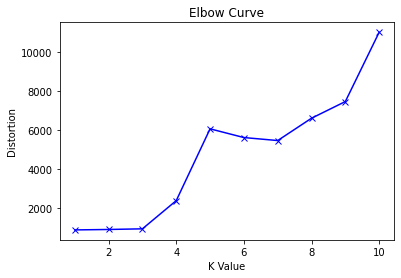

In [67]:
plt.plot(K, inertia, 'bx-')
plt.title("Elbow Curve")
plt.xlabel("K Value")
plt.ylabel("Distortion")

In [68]:
# # code to perform k-means

# distortions  = []
# k = range(10):
#     model = KmeansModel(n_clusters = k)
#     model.fit(dataframe)
#     distance = 0 # this has the distance from their respective cintroids for evaluation purposes
#     cost = sum(distance) / (2 * len(data[0]))
#     cost = np.array(cost)
#     cost = cost.item()
#     distortions.append(cost)

# plt.plot(X_train, distortions)
# plt.title("Elbow Curve")
# plt.xlabel("K Value")
# plt.ylabel("Distortion")

# # here we can see that k = 3 is forming valid clusters



# References

https://www.youtube.com/watch?v=ywgJLK5m0Sg

https://www.kaggle.com/achintyatripathi/kmeans-from-scratch-with-silhoutte-and-elbow-curve

https://predictivehacks.com/k-means-elbow-method-code-for-python/

